# Multi-Class Prediction of Obesity Risk


## Preparação do ambiente e dos dados


### Imports e Configurações Gerais


In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import numpy as np
# import missingno as msno
# import json
# import math

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# seaborn.set_theme()

### Funções


#### invalid_values_count ( )


In [43]:
def invalid_values_count (dataframe):
    """
    Retorna dataframe contendo a contagem de valores inválidos (None, NaN, NaT) em cada coluna do dataframe passado como parâmetro.
    """

    data_dict = {
        c:[(dataframe.shape[0] - dataframe[c].count())]
        for c in dataframe.columns
        }

    return pd.DataFrame(data = data_dict, index = ['Nº de reg. inválidos']).T

### Carregamento dos Dados Rotulados (Completos)


In [44]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Análise Exploratória


### Visão Geral


Os dados estão todos completos, sem valores faltantes ou evidentemente inválidos (ex: NaN) em nenhuma coluna.

Há [Informações sobre o significado de cada coluna](https://www.kaggle.com/competitions/playground-series-s4e2/discussion/472516) em comentário no Kaggle.


In [45]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [47]:
invalid_values_count(train)

,Nº de reg. inválidos
id,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0


### Atributos categóricos


#### Gender

Pela característica do atributo (não ter uma ordem), certamente vamos utilizar o One Hot Encoding.

In [48]:
print(train.Gender.unique())

['Male' 'Female']


#### CALC


Para este atributo há uma ordem muito clara entre as classes, de maneira que podemos fazer ordinal encoding, mas também podemos fazer one hot encoding, que possui a vantagem de não atribuir uma escala às classes. Mas ambos os métodos podem ser testados.


In [49]:
print(train.CALC.unique())

['Sometimes' 'no' 'Frequently']


#### MTRANS


Neste atributo podemos proceder de duas maneiras principais:

- Utilizar One Hot Encoding. Escolha que considero mais certeira por não atribuir ordem ou escala.
- Definir uma ordem e utilizar ordinal encoding. Neste caso podemos olhar o comportamento do atributo em relação ao target para validar a ordem escolhida para cada classe.


In [50]:
print(train.MTRANS.unique())

['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']


#### NObeyesdad (Target)


Para este atributo será feito ordinal encoding, porque há uma ordem clara entre as classes e este é o target, portanto está é a técnica mais usual para que a saída do algoritmo possa ser numérica.


In [51]:
print(train.NObeyesdad.unique())

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


In [52]:
target_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']


### Matriz de dispersão

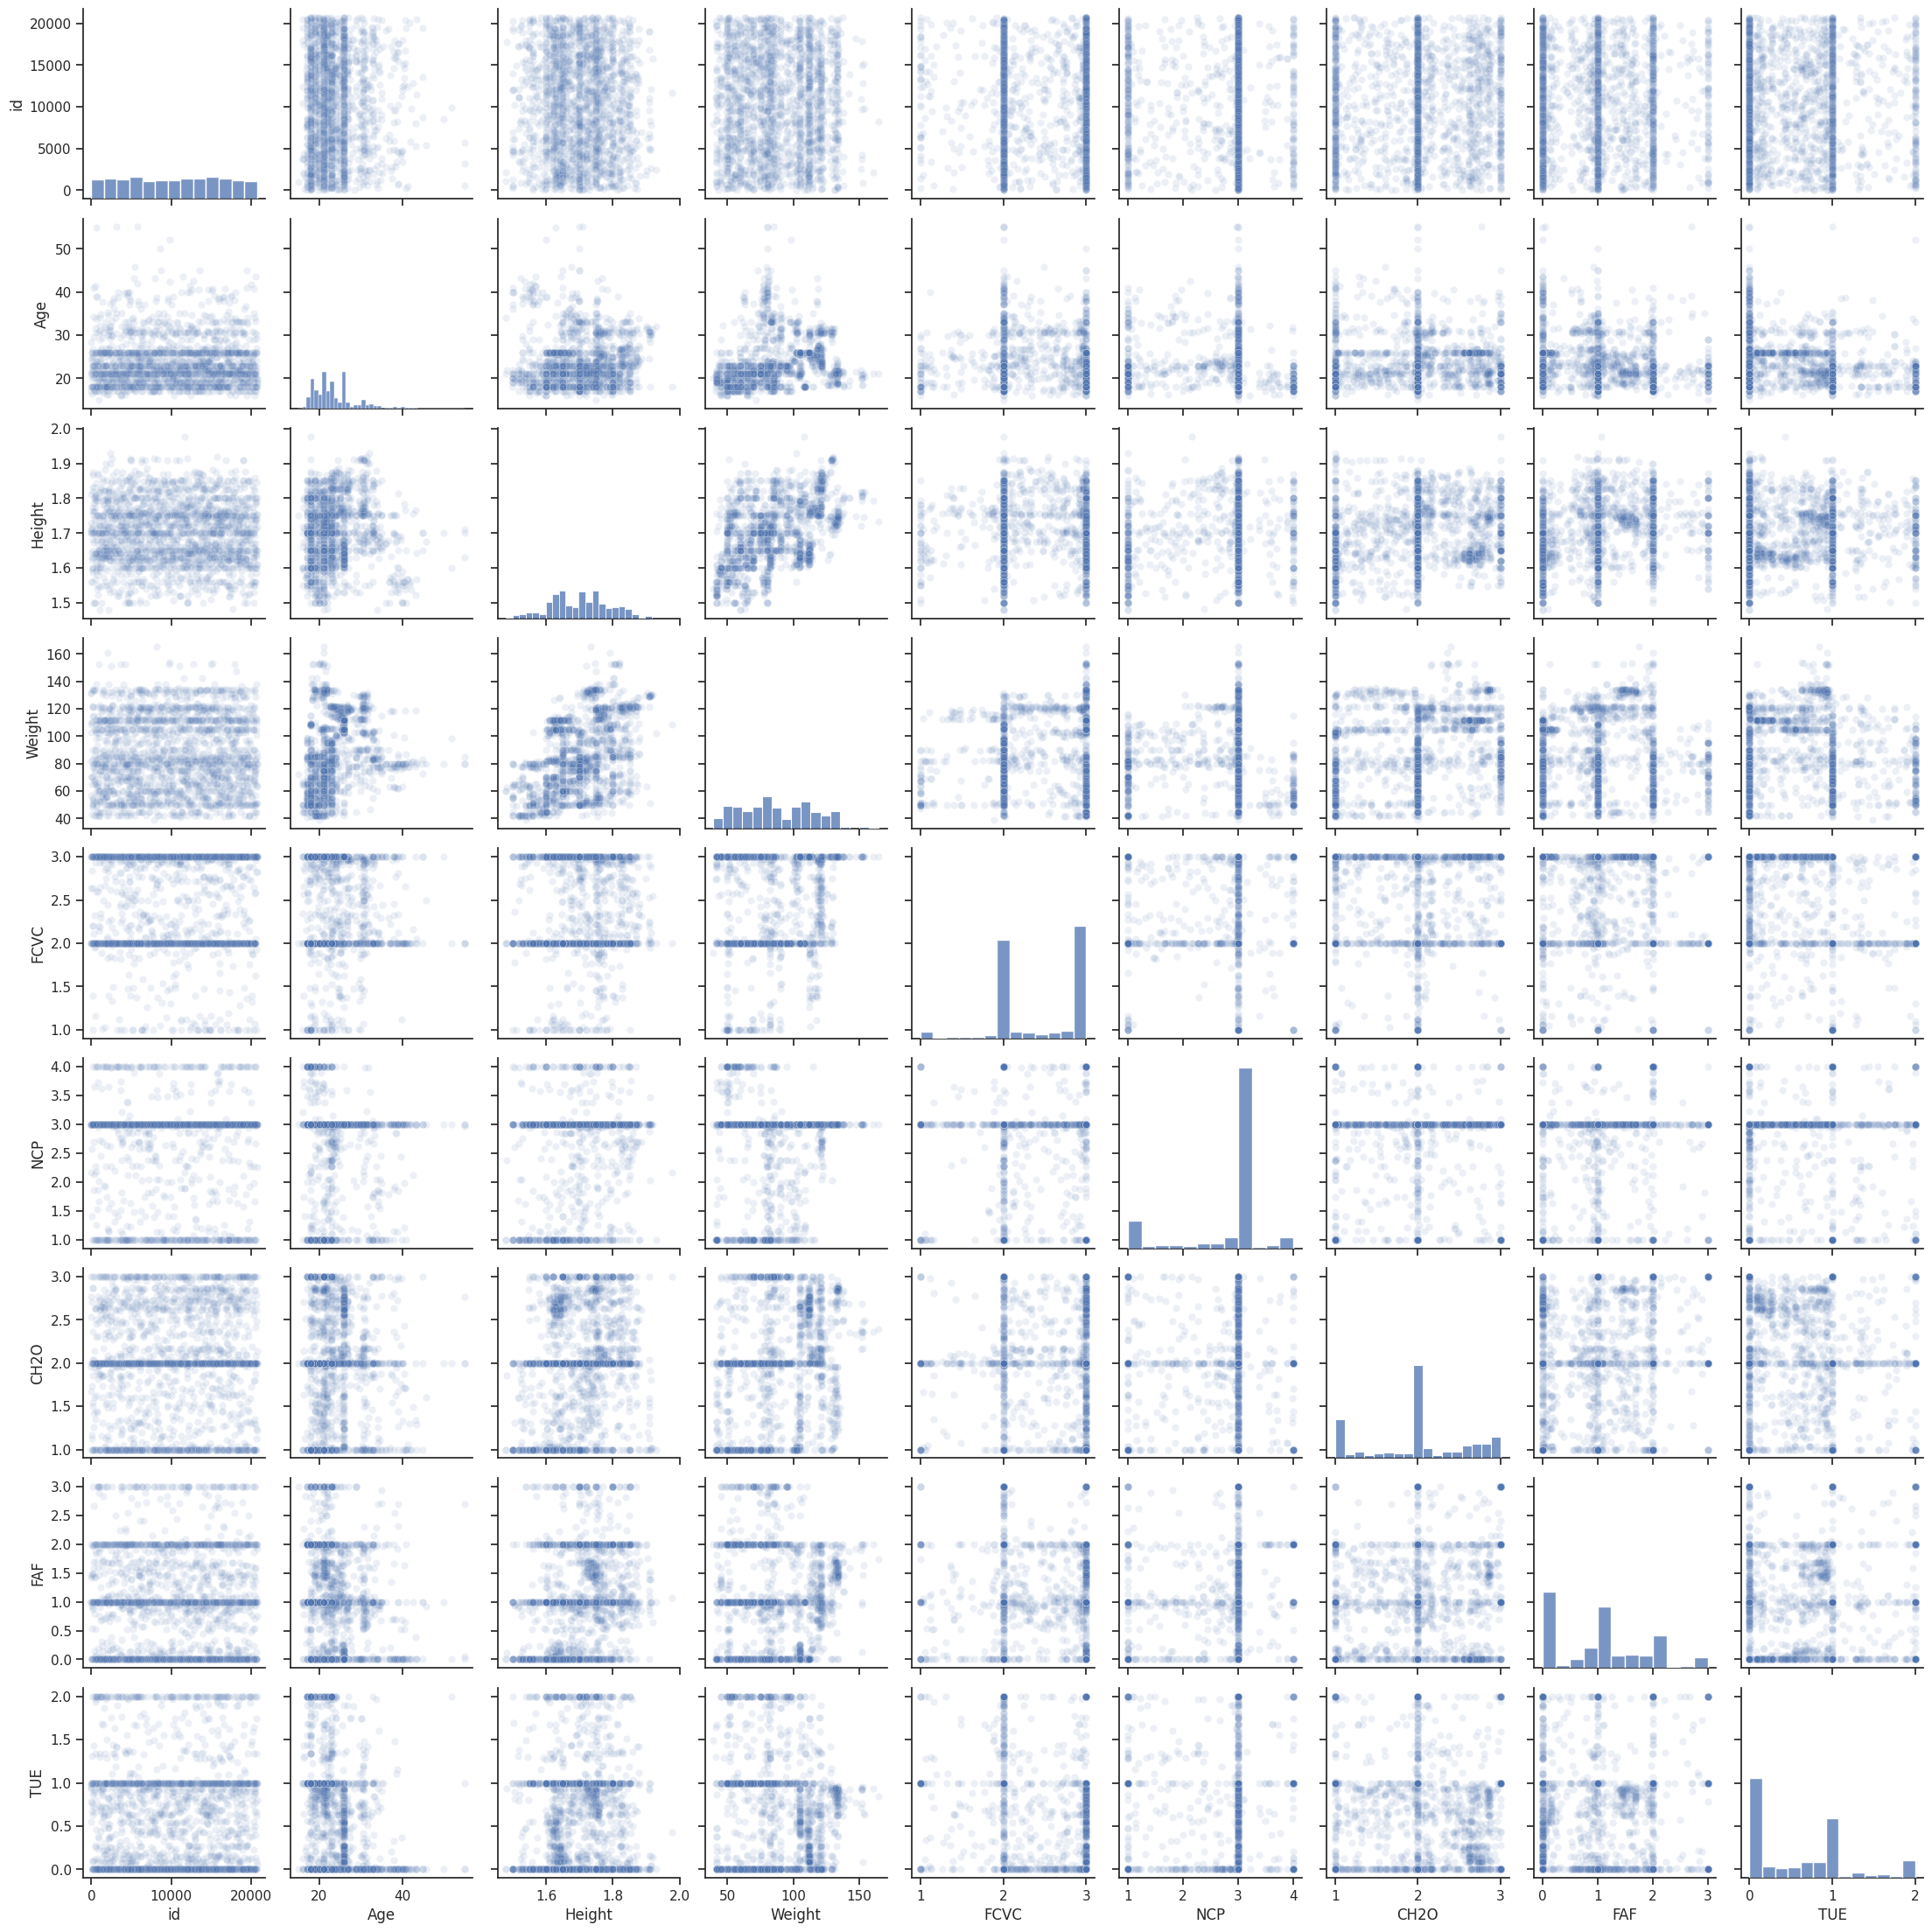

In [53]:
sns.set_theme(style='ticks')
plot = sns.pairplot(train.sample(2000), plot_kws={'alpha':0.1})
# plot = sns.pairplot(train, plot_kws={'alpha':0.05})

## Pré-processamento


In [54]:
# Criar o encoder com a ordem desejada
target_encoder = OrdinalEncoder(categories=[target_order], dtype=int)

train["NObeyesdad_encoded"] = target_encoder.fit_transform(
    train[["NObeyesdad"]]
).flatten()

# 3. Separar features (X) e target (y)
features = train.drop(["NObeyesdad", "NObeyesdad_encoded"], axis=1)
target = train["NObeyesdad_encoded"]

# 4. Dividir em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# 5. Criar o ColumnTransformer para aplicar One-Hot Encoding nas colunas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Gender', 'CALC', 'MTRANS'])
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

model.fit(X_train, y_train)


# 6.2 Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# 7. Avaliar a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do modelo: {accuracy:.2f}")

# 8. Relatório de classificação detalhado (opcional)
print("\nRelatório de Classificação:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=target_order,  # Nomes originais para melhor interpretação
    )
)

# 9. Exemplo de como decodificar uma previsão
# exemplo_pred = model.predict(X_test.iloc[[0]])[
#     0]  # Primeira amostra do teste
# classe_original = target_encoder.inverse_transform([[exemplo_pred]])[0][0]
# print(f"\nExemplo de previsão decodificada: {classe_original}")


Acurácia do modelo: 0.89

Relatório de Classificação:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.92      0.92       524
      Normal_Weight       0.83      0.87      0.85       626
 Overweight_Level_I       0.77      0.71      0.74       484
Overweight_Level_II       0.75      0.77      0.76       514
     Obesity_Type_I       0.87      0.86      0.87       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804

           accuracy                           0.89      4152
          macro avg       0.87      0.87      0.87      4152
       weighted avg       0.89      0.89      0.89      4152



In [55]:
X_train

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
9958,9958,Male,17.000000,1.770000,97.000000,yes,yes,3.000000,3.000000,Always,no,2.000000,no,3.000000,1.000000,no,Automobile
7841,7841,Male,22.667596,1.753389,54.877111,yes,yes,2.000000,4.000000,Sometimes,no,2.000000,no,2.000000,1.000000,no,Public_Transportation
9293,9293,Male,21.838323,1.819867,122.024954,yes,yes,3.000000,2.880817,Sometimes,no,1.645338,no,0.739881,0.000000,Sometimes,Public_Transportation
15209,15209,Female,41.000000,1.580000,80.000000,yes,yes,2.000000,3.000000,Sometimes,no,1.000000,no,0.000000,0.000000,Sometimes,Automobile
16515,16515,Male,23.000000,1.800000,95.000000,yes,no,3.000000,3.000000,Sometimes,no,3.000000,no,2.000000,1.000000,Frequently,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,11284,Female,18.000000,1.722461,80.442775,yes,yes,2.628791,2.562895,Sometimes,no,1.844645,no,0.288032,0.722276,no,Public_Transportation
11964,11964,Male,22.000000,1.750000,95.000000,yes,no,3.000000,3.000000,Sometimes,no,2.000000,no,3.000000,0.000000,Sometimes,Public_Transportation
5390,5390,Male,21.000000,1.620000,68.000000,no,yes,2.000000,3.000000,Always,no,3.000000,no,2.000000,0.000000,Sometimes,Public_Transportation
860,860,Female,26.000000,1.650125,111.939671,yes,yes,3.000000,3.000000,Sometimes,no,2.770732,no,0.000000,0.237307,Sometimes,Public_Transportation


## Treinamento


## Resultado
